In [16]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [17]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import grad_utils as model

# load data

In [18]:
data = np.load('simulation_data.npy')
latent = np.load('simulation_latent.npy')

In [19]:
data.shape, latent.shape

((10, 20, 20), (10, 20))

# parameters

In [89]:
# optimization parameters
l_penalty = 0.02
max_iter = 1000
ths = 1e-12

# vanilla PGD parameters
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

# operators

In [118]:
def objective_l2(beta, game_matrix_list, l_penalty):
    '''
    compute the objective of the model
    ----------
    Input:
    beta: TxN array or a TN vector
    game_matrix_list: TxNxN array
    ----------
    Output:
    objective: negative log likelihood + l2 penalty
    '''
    # reshape beta into TxN array
    T, N = game_matrix_list.shape[0:2]
    beta = np.reshape(beta, [T,N])
    
    # compute l2 penalty
    l2_penalty = np.sum(np.square(beta[:-1]-beta[1:]))
    
    return model.neg_log_like(beta, game_matrix_list) + l_penalty * l2_penalty

In [119]:
def prox_l2(beta, s, l):
    '''
    proximal operator for l2-penalty
    '''
    n = np.array(beta).shape[0]
    
    # define banded matrix
    banded = np.block([
        [np.zeros([1,1]), (-1)*s*l*np.ones([1,n-1])],
        [(1+s*l)*np.ones([1,1]), (1+2*s*l)*np.ones([1,n-2]), (1+s*l)*np.ones([1,1])],
        [(-1)*s*l*np.ones([1,n-1]), np.zeros([1,1])]
    ])
    
    # solve banded @ beta* = beta
    return spl.solve_banded((1,1), banded, beta, True, True, False)

# PGD without backtracking line search

In [126]:
# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2])

# initialize record
objective_vanilla = [objective_l2(beta, data, l_penalty)]
print("initial objective value: %f"%objective_vanilla[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = model.grad_nl(beta, data).reshape([T,N])
    
    # proximal gradient update
    beta = prox_l2(beta - step_size*gradient, step_size, l_penalty)
    
    # objective value
    objective_vanilla.append(objective_l2(beta, data, l_penalty))
    
    print("%d-th PGD, objective value: %f"%(i+1, objective_vanilla[-1]))
    if objective_vanilla[-2] - objective_vanilla[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 13028.394406
1-th PGD, objective value: 10630.059382
2-th PGD, objective value: 10536.897192
3-th PGD, objective value: 10530.367597
4-th PGD, objective value: 10528.783415
5-th PGD, objective value: 10528.198805
6-th PGD, objective value: 10527.951111
7-th PGD, objective value: 10527.838772
8-th PGD, objective value: 10527.785805
9-th PGD, objective value: 10527.760241
10-th PGD, objective value: 10527.747750
11-th PGD, objective value: 10527.741625
12-th PGD, objective value: 10527.738634
13-th PGD, objective value: 10527.737194
14-th PGD, objective value: 10527.736521
15-th PGD, objective value: 10527.736223
16-th PGD, objective value: 10527.736105
17-th PGD, objective value: 10527.736070
18-th PGD, objective value: 10527.736071
Converged!


/home/hbong/miniconda3/envs/sklearnprod0/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Use of the "debug" keyword is deprecated and this keyword will be removed in the future versions of SciPy.


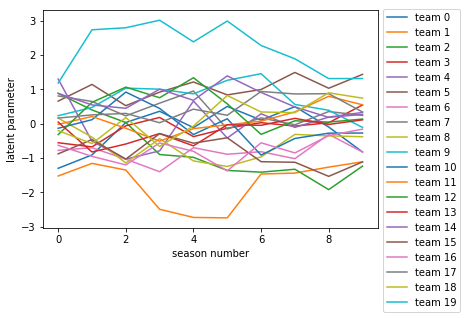

In [121]:
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0))

# PGD with backtracking line search

In [122]:
# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2])
nll = model.neg_log_like(beta, data)

# initialize record
objective_wback = [objective_l2(beta, data, l_penalty)]
print("initial objective value: %f"%objective_wback[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = model.grad_nl(beta, data).reshape([T,N])
    
    # backtracking line search
    s = step_size
    for j in range(max_back):
        beta_new = prox_l2(beta - s*gradient, s, l_penalty)
        beta_diff = beta_new - beta
        
        nll_new = model.neg_log_like(beta_new, data)
        nll_back = (nll + np.sum(gradient * beta_diff) 
                    + np.sum(np.square(beta_diff)) / (2*s))
        
        if nll_new <= nll_back:
            break
        s *= b
    
    # proximal gradient update
    beta = beta_new
    nll = nll_new
    
    # record objective value
    objective_wback.append(objective_l2(beta, data, l_penalty))
    
    print("%d-th PGD, objective value: %f"%(i+1, objective_wback[-1]))
    if objective_wback[-2] - objective_wback[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 13028.394406
1-th PGD, objective value: 11016.354869
2-th PGD, objective value: 10574.328008
3-th PGD, objective value: 10540.420753
4-th PGD, objective value: 10532.233998
5-th PGD, objective value: 10529.553249
6-th PGD, objective value: 10528.529605
7-th PGD, objective value: 10528.099677
8-th PGD, objective value: 10527.907638
9-th PGD, objective value: 10527.818383
10-th PGD, objective value: 10527.775839
11-th PGD, objective value: 10527.755254
12-th PGD, objective value: 10527.745225
13-th PGD, objective value: 10527.740342
14-th PGD, objective value: 10527.737986
15-th PGD, objective value: 10527.736871
16-th PGD, objective value: 10527.736364
17-th PGD, objective value: 10527.736150
18-th PGD, objective value: 10527.736074
19-th PGD, objective value: 10527.736059
20-th PGD, objective value: 10527.736069
Converged!


/home/hbong/miniconda3/envs/sklearnprod0/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Use of the "debug" keyword is deprecated and this keyword will be removed in the future versions of SciPy.


# accelerated PGD

In [128]:
# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2])
beta_diff = np.zeros(data.shape[:2])

# initialize record
objective_acc = [objective_l2(beta, data, l_penalty)]
print("initial objective value: %f"%objective_acc[-1])

# iteration
for i in range(100):
    # compute gradient
    gradient = model.grad_nl(beta, data).reshape([T,N])
    
    # proximal gradient update
    beta_new = beta + ((i-1)/(i+2)) * beta_diff
    beta_new = prox_l2(beta_new - step_size*gradient, step_size, l_penalty)
    beta_diff = beta_new - beta
    beta = beta_new
    
    # objective value
    objective_acc.append(objective_l2(beta, data, l_penalty))
    
    print("%d-th PGD, objective value: %f"%(i+1, objective_acc[-1]))
#     if objective_acc[-2] - objective_acc[-1] < ths:
#         print("Converged!")
#         break
        
# if i >= max_iter:
#     print("Not converged.")

initial objective value: 13028.394406
1-th PGD, objective value: 10630.059382
2-th PGD, objective value: 10536.897192
3-th PGD, objective value: 10532.579947
4-th PGD, objective value: 10529.267676
5-th PGD, objective value: 10528.490200
6-th PGD, objective value: 10528.500819
7-th PGD, objective value: 10528.192528
8-th PGD, objective value: 10528.037023
9-th PGD, objective value: 10527.937662
10-th PGD, objective value: 10527.866214
11-th PGD, objective value: 10527.825064
12-th PGD, objective value: 10527.827993
13-th PGD, objective value: 10527.824935
14-th PGD, objective value: 10527.794167
15-th PGD, objective value: 10527.772710
16-th PGD, objective value: 10527.768024
17-th PGD, objective value: 10527.770723
18-th PGD, objective value: 10527.769571
19-th PGD, objective value: 10527.763875
20-th PGD, objective value: 10527.758557
21-th PGD, objective value: 10527.752447
22-th PGD, objective value: 10527.748398
23-th PGD, objective value: 10527.747358
24-th PGD, objective value: 

/home/hbong/miniconda3/envs/sklearnprod0/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Use of the "debug" keyword is deprecated and this keyword will be removed in the future versions of SciPy.


41-th PGD, objective value: 10527.738279
42-th PGD, objective value: 10527.738853
43-th PGD, objective value: 10527.738947
44-th PGD, objective value: 10527.738273
45-th PGD, objective value: 10527.737818
46-th PGD, objective value: 10527.737731
47-th PGD, objective value: 10527.737750
48-th PGD, objective value: 10527.737667
49-th PGD, objective value: 10527.737379
50-th PGD, objective value: 10527.737137
51-th PGD, objective value: 10527.737148
52-th PGD, objective value: 10527.737305
53-th PGD, objective value: 10527.737595
54-th PGD, objective value: 10527.737760
55-th PGD, objective value: 10527.737448
56-th PGD, objective value: 10527.737136
57-th PGD, objective value: 10527.737063
58-th PGD, objective value: 10527.736893
59-th PGD, objective value: 10527.736850
60-th PGD, objective value: 10527.736891
61-th PGD, objective value: 10527.736691
62-th PGD, objective value: 10527.736582
63-th PGD, objective value: 10527.736733
64-th PGD, objective value: 10527.736924
65-th PGD, objec

# objective plot

In [129]:
obj_opt = np.min([np.min(objective_vanilla), 
                  np.min(objective_wback),
                  np.min(objective_acc)]) - 0.01

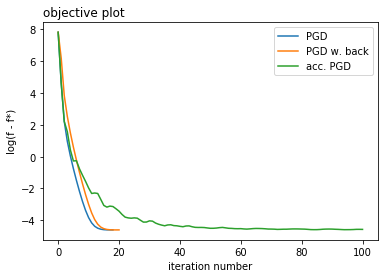

In [131]:
plt.plot(np.log(objective_vanilla - obj_opt), label="PGD")
plt.plot(np.log(objective_wback - obj_opt), label="PGD w. back")
plt.plot(np.log(objective_acc - obj_opt), label="acc. PGD")
plt.title("objective plot", loc='left')
plt.xlabel("iteration number")
plt.ylabel("log(f - f*)")
plt.legend()